# 房子租金影响因素回归分析

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 1. 读取数据

### 1.1 获取数据基本信息

In [2]:
csv_files = glob.glob(os.path.join(os.getcwd(), "data/RentFromDanke/*.csv"))
houses = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
print(f"The number of rows: {houses.shape[0]}")
print(f"The number of columns: {houses.shape[1]}")
houses.dtypes

The number of rows: 7697
The number of columns: 9


价格     object
面积     object
编号     object
户型     object
楼层     object
位置1    object
位置2    object
小区     object
地铁     object
dtype: object

注意到价格列和面积列存在空值或非数值类型值, 需要进行转换. 同时因为列的数据类型并不统一, 所以在转换列的属性后再进行重复值检查.

In [3]:
houses["价格"] = pd.to_numeric(houses["价格"], errors="coerce")
houses["面积"] = pd.to_numeric(houses["面积"], errors="coerce")
houses = houses.convert_dtypes()
houses.dtypes

价格              Int64
面积              Int64
编号     string[python]
户型     string[python]
楼层     string[python]
位置1    string[python]
位置2    string[python]
小区     string[python]
地铁     string[python]
dtype: object

### 1.2 列名分类

In [4]:
IDENTIFIERS = ["编号"]
TARGET_COLUMNS = ["价格"]
CONTINUOUS_COLUMNS = ["面积"]
DISCRETE_COLUMNS = ["楼层", "户型", "位置1", "位置2", "小区", "地铁"]

这里首先对列名进行属性分类, 便于后续分析. 注意 `DISCRETE_COLUMNS` 并不是绝对意义上的离散列, 在后续的特征工程时会根据具体情况进行处理. `CONTINUOUS_COLUMNS` 和 `DISCRETE_COLUMNS` 将作为最终确定的特征列进行线性回归模型的训练.

## 2. 数据清理

### 2.1 删除无用信息
- 除了编号列外, 其他列均为空的行
- 价格为空的行

In [5]:
print("除了编号列外, 其他列均为空的行:")
houses[houses.drop(columns=IDENTIFIERS).isnull().all(axis=1)]

除了编号列外, 其他列均为空的行:


,价格,面积,编号,户型,楼层,位置1,位置2,小区,地铁
27,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
73,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
86,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
136,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
159,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
7532,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7543,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7609,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [6]:
print("价格为空的行:")
houses[houses["价格"].isnull()]

价格为空的行:


,价格,面积,编号,户型,楼层,位置1,位置2,小区,地铁
27,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
73,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
86,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
136,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
159,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
7532,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7543,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7609,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [7]:
houses.dropna(
    how="all",
    subset=[col for col in houses.columns if col not in IDENTIFIERS],
    inplace=True,
)
houses.dropna(subset=TARGET_COLUMNS, inplace=True)
houses.drop_duplicates(inplace=True)
print(f"The number of rows: {houses.shape[0]}")
print(f"The number of columns: {houses.shape[1]}")

The number of rows: 5541
The number of columns: 9


幸运的是, 剩下的数据几乎不存在缺失值. 但由于很多列实际上是字符串, 虽然不存在空字符串, 在进行提取转换时可能得到无效数值, 所以后续需要进一步判断.

### 2.2 检查极端值

In [8]:
print(houses[["价格", "面积"]].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

                价格         面积
count       5541.0     5541.0
mean   2662.039343  15.718101
std      1168.3151  12.899736
min          930.0        4.0
1%          1294.0        7.0
5%          1510.0        8.0
50%         2430.0       12.0
95%         4910.0       46.0
99%         7548.0       79.0
max        11740.0      123.0


由于价格和面积两列是原生的数值型数据, 可以直接进行极端值检查. 观察发现, 价格和面积的最值都在合理区间, 因此初步判定不存在极端值.

In [9]:
houses["单位租金"] = (houses["价格"] / houses["面积"]).astype(int)

这里新建一个列 `单位租金` 作为单位面积的价格, 用于后续分析.

### 2.3 特征工程

- **户型提取**

In [10]:
assert houses["户型"].str.match(r"^\d+室\d+卫$").all()

观察发现, 户型列所有数据都满足 `n室n卫` 的格式, 因此可以直接提取出室卫的特征.

In [11]:
houses["房间"] = houses["户型"].str.extract(r"(\d+)室").astype(int)
houses["卫生间"] = houses["户型"].str.extract(r"(\d+)卫").astype(int)
houses["卫房比"] = houses["卫生间"] / houses["房间"]

提取后得到房间列和卫生间列, 这里再构造一个新的列卫房比, 衡量一个房间对应的卫生间数量.

In [12]:
print(houses[["房间", "卫生间", "卫房比"]].describe())

                房间          卫生间          卫房比
count  5541.000000  5541.000000  5541.000000
mean      3.126331     1.043133     0.374864
std       0.987244     0.229853     0.174083
min       1.000000     0.000000     0.000000
25%       3.000000     1.000000     0.250000
50%       3.000000     1.000000     0.333333
75%       4.000000     1.000000     0.333333
max       8.000000     4.000000     1.000000


观察发现, 房间和卫生间数均不存在极端值. 由于卫生间有超过 75% 的数据为 1, 可以初步判定其不宜直接作为特征, 来减少多重共线性的影响.

**楼层提取**

In [13]:
assert houses["楼层"].str.match(r"^\d+/\d+层$").all()

观察发现, 楼层列所有数据都满足 `当前楼层数/总楼层数` 的格式, 因此可以直接提取出两个特征.

In [14]:
houses["当前楼层"] = houses["楼层"].str.extract(r"(\d+)/").astype(int)
houses["总楼层"] = houses["楼层"].str.extract(r"/(\d+)层$").astype(int)
houses["便利性"] = np.where((houses["总楼层"] >= 7) | (houses["总楼层"] <= 2), 1, 0)
houses["相对高度"] = houses["当前楼层"] / houses["总楼层"]

相对高度列, 用于表示当前楼层相对于总楼层的高度; 便利性衡量上下楼的方便, 低层楼(层数小于 3 )和高层楼(层数大于 7 )的便利性为 1, 其他楼层为0. 层数大于 7 的楼房往往具有电梯, 所以其便利性也为 1.

In [15]:
houses[["当前楼层", "总楼层", "便利性", "相对高度"]].describe()

,当前楼层,总楼层,便利性,相对高度
count,5541.000000,5541.000000,5541.000000,5541.000000
mean,7.161343,13.756723,0.594838,0.544389
std,6.135618,8.340174,0.490968,0.290681
min,1.000000,2.000000,0.000000,0.031250
25%,3.000000,6.000000,0.000000,0.310345
50%,5.000000,11.000000,1.000000,0.538462
75%,10.000000,21.000000,1.000000,0.814815
max,33.000000,39.000000,1.000000,3.333333


观察发现, 楼层数据也不存在极端值

**地铁距离提取**

In [16]:
def extract_distance(value):
    match = re.search(r"地铁：距.*站(\d+)米$", value)
    if match:
        return int(match.group(1))
    else:
        return np.nan


houses["地铁距离"] = houses["地铁"].apply(extract_distance)
houses[["地铁", "小区", "地铁距离"]].head()

,地铁,小区,地铁距离
0,地铁：距房山线良乡大学城西站550米,紫汇家园,550.0
1,地铁：距7号线广渠门内站650米,绿景苑,650.0
2,地铁：距14号线东段景泰站450米,定安里,450.0
3,地铁：距八通线管庄站500米,京通苑阳光华苑,500.0
4,地铁：距6号线十里堡站850米,天天朝阳,850.0


In [17]:
houses["地铁距离"].describe()

count    5529.000000
mean      959.124616
std       710.482954
min        50.000000
25%       500.000000
50%       750.000000
75%      1200.000000
max      4550.000000
Name: 地铁距离, dtype: float64

地观察发现, 地铁距离不存在极端值, 但是地铁列中存在信息丢失, 这里通过中位数进行填充地铁距离.

In [18]:
houses["地铁距离"] = houses["地铁距离"].fillna(houses["地铁距离"].median())
houses["地铁距离"].describe()

count    5541.000000
mean      958.671720
std       709.779651
min        50.000000
25%       500.000000
50%       750.000000
75%      1200.000000
max      4550.000000
Name: 地铁距离, dtype: float64

**位置信息提取**

In [19]:
houses["位置1"].value_counts()

位置1
朝阳区     1729
通州区      949
丰台区      681
昌平区      466
大兴区      353
海淀区      344
顺义区      339
房山区      322
石景山区     162
东城区      101
西城区       79
门头沟区      16
Name: count, dtype: Int64

位置 1 作为行政区域, 类别少, 可以单独在后续进行编码.

In [20]:
houses["位置2"].value_counts()

位置2
通州北关     194
物资学院路    116
管庄       108
梨园       104
黄渠       102
        ... 
丰台科技园      1
阜成门        1
西土城        1
白堆子        1
鼓楼大街       1
Name: count, Length: 289, dtype: Int64

位置 2 为房屋所处的区域, 该区域单位面积的租金的中位数一定程度上可以用于判断租金水平.

In [21]:
houses["区域单位租金中值"] = houses.groupby("位置2")["单位租金"].transform("median")
houses["区域单位租金中值"].describe()

count    5541.000000
mean      197.022198
std        45.776508
min        94.000000
25%       165.000000
50%       196.000000
75%       225.000000
max       488.000000
Name: 区域单位租金中值, dtype: float64

In [22]:
houses["小区"].value_counts()

小区
花香东苑      50
新建村小区     48
连心园西区     47
管庄新村      44
友谊嘉园三期    43
          ..
长青园小区      1
北京经开汀塘     1
黄村东里       1
龙泉苑小区      1
远中悦麒       1
Name: count, Length: 1839, dtype: Int64

由于小区名信息过于分散且数据量较小, 无法提取有用信息, 故考虑舍弃该列.

In [23]:
houses.drop(columns=["小区"], inplace=True)

**特征列整合**

In [24]:
houses.dtypes

价格                   Int64
面积                   Int64
编号          string[python]
户型          string[python]
楼层          string[python]
位置1         string[python]
位置2         string[python]
地铁          string[python]
单位租金                 int64
房间                   int64
卫生间                  int64
卫房比                float64
当前楼层                 int64
总楼层                  int64
便利性                  int64
相对高度               float64
地铁距离               float64
区域单位租金中值           float64
dtype: object

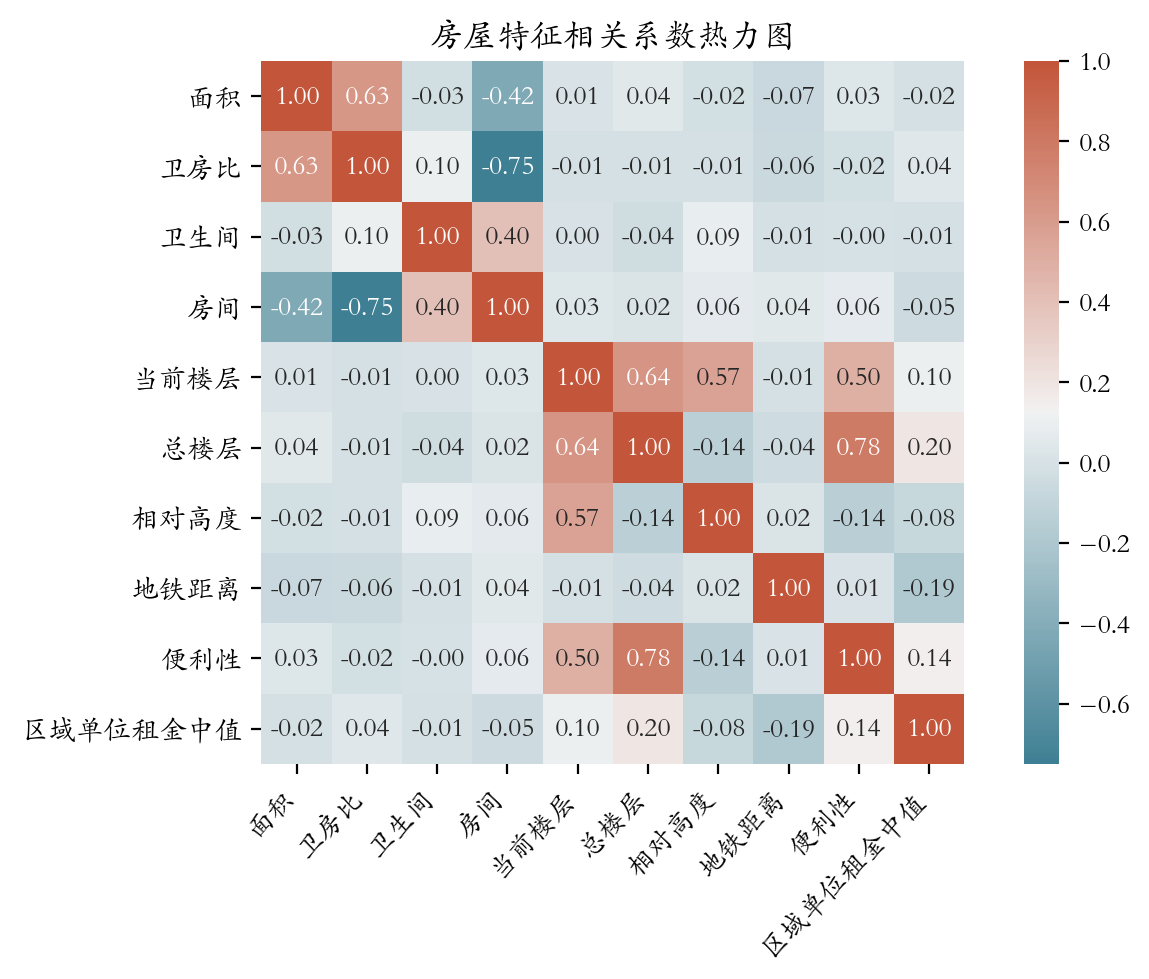

In [25]:
CORRELATION_COLUMNS = [
    "面积",
    "卫房比",
    "卫生间",
    "房间",
    "当前楼层",
    "总楼层",
    "相对高度",
    "地铁距离",
    "便利性",
    "区域单位租金中值",
]
corr_matrix = houses[CORRELATION_COLUMNS].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    fmt=".2f",
    square=True,
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("房屋特征相关系数热力图")
plt.tight_layout()
plt.show()

1. 去除掉总楼层, 当前楼层数和卫生间数列, 减少多重共线性的影响. 总楼层和当前楼层数反映的信息用相对高度和便利性两个特征来替代, 卫生间数量相当大一部分都是1, 而实际上卫房比更能反映出卫生间在整个房子的稀缺程度, 所以选用卫房比代替特征卫生间的数量.
2. 即便房间数和卫房比有较高的负相关关系, 这里保留了房间数和面积, 因为根据一般常识, 房间数和卫房比对租金价格都有比较大的影响, 同样面积列也保留, 我们留到后面考虑多重共线性的影响.

In [26]:
DISCRETE_COLUMNS = ["卫房比", "房间", "相对高度", "地铁距离", "便利性", "位置1"]
CONTINUOUS_COLUMNS = ["面积", "区域单位租金中值"]

### 2.4 数据变换

**对地铁距离进行分级**

In [27]:
bins = [0, 500, 1000, np.inf]
labels = [0, 1, 2]
houses["地铁距离分级"] = pd.cut(
    houses["地铁距离"], bins=bins, labels=labels, right=False
).astype(int)
houses["地铁距离分级"].describe()

count    5541.000000
mean        1.112074
std         0.742885
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: 地铁距离分级, dtype: float64

In [28]:
DISCRETE_COLUMNS.remove("地铁距离")
DISCRETE_COLUMNS.append("地铁距离分级")

1. 对地铁距离用中位数填充, 减少极端值的影响.
2. 相比于具体的地铁距离, 可以认为客户对地铁距离的区间是更加敏感的, 所以对地铁距离进行进一步分级. 具体来说, 0~500m 对应的区间记号为 0, 500~1000m 对应的区间记号为 1, 1000m 以上对应的区间记号为 2. 记号值越大, 代表距离地铁站越远.

**对连续型变量进行标准化**

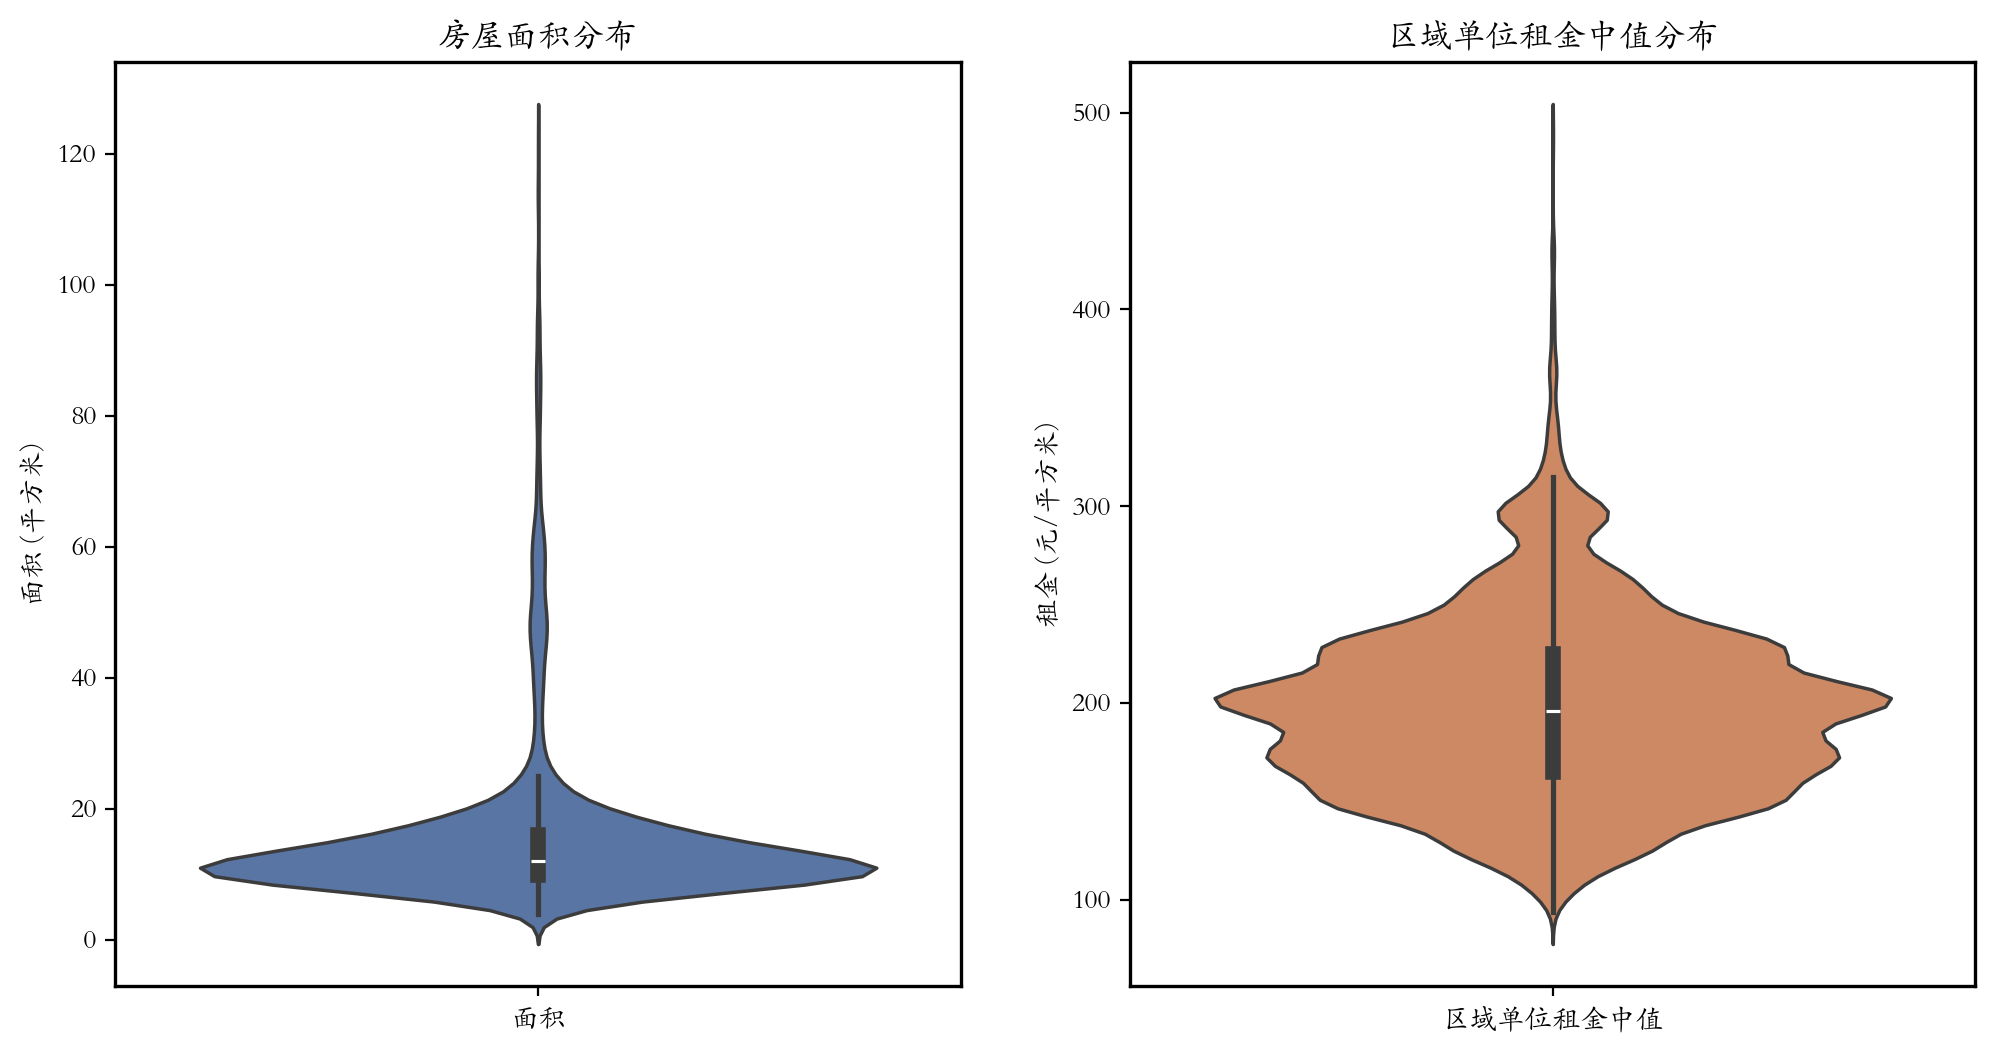

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.violinplot(data=pd.DataFrame(houses["面积"]), ax=axes[0], color="#4C72B0")
axes[0].set_title("房屋面积分布")
axes[0].set_ylabel("面积 (平方米)")

sns.violinplot(
    data=pd.DataFrame(houses["区域单位租金中值"]), ax=axes[1], color="#DD8452"
)
axes[1].set_title("区域单位租金中值分布")
axes[1].set_ylabel("租金 (元/平方米)")

for ax in [axes[0], axes[1]]:
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

plt.show()

两个特征的分布均存在明显的偏态, 因此选择对其进行标准化处理(而非归一化, 因为归一化容易改变原始数据分布).

In [30]:
scaler = StandardScaler()
houses[["面积_s", "区域单位租金中值_s"]] = scaler.fit_transform(
    houses[["面积", "区域单位租金中值"]]
)
CONTINUOUS_COLUMNS = ["面积_s", "区域单位租金中值_s"]

**对字符串类型的离散型数据进行编码**

In [31]:
dummy_vars = pd.get_dummies(houses["位置1"], prefix="位置1", drop_first=True)
houses = pd.concat([houses, dummy_vars], axis=1)
DISCRETE_COLUMNS.remove("位置1")
DISCRETE_COLUMNS += list(dummy_vars.columns)

**特征选择**

In [32]:
feature_columns = DISCRETE_COLUMNS + CONTINUOUS_COLUMNS
target = "价格"
X = houses[feature_columns].astype(float)
y = houses[target]

X_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data["特征"] = X_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])
]
vif_data.sort_values("VIF", ascending=False)

,特征,VIF
0,const,128.069887
10,位置1_朝阳区,13.191506
14,位置1_通州区,9.078619
6,位置1_丰台区,7.122153
9,位置1_昌平区,5.446257
11,位置1_海淀区,4.717415
7,位置1_大兴区,4.377385
8,位置1_房山区,4.316868
16,位置1_顺义区,4.315516
1,卫房比,3.171800


除了位置1列的离散编码列, 其他列的 VIF 值均小于 5, 说明这些列之间多重共线关系比较弱. 而由于位置1列是行政区域编码列, 本身就具有较强的相关性, 所以仍然可以予以保留.

## 3. 线性回归模型

### 3.1 模型构建

In [33]:
train_df, test_df = train_test_split(houses, test_size=0.3, random_state=2024)

X_train = train_df[feature_columns].astype(float)
X_test = test_df[feature_columns].astype(float)
y_train = train_df[target]
y_test = test_df[target]

X_train_const = add_constant(X_train)
X_test_const = add_constant(X_test)

In [34]:
model = OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     价格   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1389.
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:27:13   Log-Likelihood:                -28979.
No. Observations:                3878   AIC:                         5.800e+04
Df Residuals:                    3859   BIC:                         5.811e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3484.0553     77.243     45.105      0.000    3332.615    3635.496
卫房比          548.9153     70.694      7.765      0.000     410.315     687.516
房间           -46.1319     10.722     -4.303      0.000     -67.152     -25.111
相对高度         -16.3369     24.104     -0.678      0.498     -63.594      30.921
便利性           90.5592     14.544      6.227      0.000      62.045     119.073
地铁距离分级      -136.8435      9.777    -13.996      0.000    -156.013    -117.674
位置1_丰台区     -807.5550     54.163    -14.910      0.000    -913.745    -701.365
位置1_大兴区     -975.5542     56.780    -17.181      0.000   -1086.875    -864.233
位置1_房山区    -1256.9664     59.309    -21.194      0.000   -1373.246   -1140.687
位置1_昌平区     -739.9128     55.965    -13.221      0.000    -849.636    -630.190
位置1_朝阳区     -583.4265     51.921    -11.237      0.000    -685.222    -481.630
位置1_海淀区     -437.8717     60.091     -7.287      0.000    -555.684    -320.059
位置1_石景山区    -729.6839     64.461    -11.320      0.000    -856.064    -603.303
位置1_西城区     -173.1380     77.129     -2.245      0.025    -324.356     -21.920
位置1_通州区    -1038.3901     53.155    -19.535      0.000   -1142.606    -934.175
位置1_门头沟区   -1243.1236    133.332     -9.324      0.000   -1504.532    -981.716
位置1_顺义区    -1033.0515     58.112    -17.777      0.000   -1146.984    -919.119
面积_s         836.8850      9.126     91.701      0.000     818.992     854.778
区域单位租金中值_s   280.1907     10.193     27.488      0.000     260.206     300.175
==============================================================================
Omnibus:                     1107.075   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38795.491
Skew:                           0.683   Prob(JB):                         0.00
Kurtosis:                      18.435   Cond. No.                         98.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

下面展示具体计算R^2, 修正R^2, F统计量, t统计量的过程.

In [35]:
def calculate_r_squared(model, y_train, X_train_const):
    """计算并打印R方和调整R方等统计量
    
    Args:
        model: 训练好的OLS模型
        X_train_const: 包含常数项的训练特征矩阵
        y_train: 训练集目标变量
        
    Returns:
        tuple: (R方, 调整R方)
    """
    train_pred = model.predict(X_train_const)
    y_mean = y_train.mean()
    
    TSS = np.sum((y_train - y_mean) ** 2)
    SSR = np.sum((train_pred - y_mean) ** 2) 
    SSE = np.sum((y_train - train_pred) ** 2)
    
    n = len(y_train)
    p = len(X_train_const.columns) - 1 
    
    R2 = SSR / TSS
    adj_R2 = 1 - (SSE/(n-p-1))/(TSS/(n-1))
    
    print(f"总平方和(TSS): {TSS:.2f}")
    print(f"回归平方和(SSR): {SSR:.2f}")
    print(f"残差平方和(SSE): {SSE:.2f}") 
    print(f"SSR + SSE = {(SSR + SSE):.2f}, TSS = {TSS:.2f}")
    print(f"决定系数(R^2): {R2:.4f}")
    print(f"修正决定系数(Adjusted R^2): {adj_R2:.4f}")
    
    return R2, adj_R2

R2, adj_R2 = calculate_r_squared(model, y_train, X_train_const)

总平方和(TSS): 5255938660.24
回归平方和(SSR): 4553176573.96
残差平方和(SSE): 702762086.28
SSR + SSE = 5255938660.24, TSS = 5255938660.24
决定系数(R^2): 0.8663
修正决定系数(Adjusted R^2): 0.8657


In [36]:
def calculate_f_statistic(model, y_train, X_train):
    """计算并打印F统计量及相关统计量
    
    Args:
        model: 训练好的OLS模型
        y_train: 训练集目标变量
        X_train: 训练集特征矩阵
        SSR: 回归平方和
        SSE: 残差平方和
        
    Returns:
        tuple: (F统计量, F临界值, p值)
    """
    train_pred = model.predict(X_train_const)
    y_mean = y_train.mean()

    n = len(y_train)
    p = len(X_train.columns)

    SSR = np.sum((train_pred - y_mean) ** 2)
    SSE = np.sum((y_train - train_pred) ** 2)

    F = (SSR/p)/(SSE/(n-p-1))
    
    alpha = 0.05
    F_crit = stats.f.ppf(1-alpha, p, n-p-1)
    p_value = stats.f.sf(F, p, n-p-1)
    
    print(f"F统计量: {F:.4f}")
    print(f"F临界值(α=0.05): {F_crit:.4f}")
    print(f"p值: {p_value:.10f}")
    
    return F, F_crit, p_value

F, F_crit, p_value = calculate_f_statistic(model, y_train, X_train_const)

F统计量: 1315.5725
F临界值(α=0.05): 1.5892
p值: 0.0000000000


In [37]:
def calculate_t_statistics(model, y_train, X_train_const):
    """计算并打印t统计量及相关统计量
    
    Args:
        model: 训练好的OLS模型
        X_train_const: 带常数项的训练集特征矩阵
        y_train: 训练集目标变量
        
    Returns:
        pd.DataFrame: t检验结果表格
    """
    params = model.params
    
    y_pred = model.predict(X_train_const)
    SSR = np.sum((y_train - y_pred) ** 2)
    
    n = len(y_train)
    p = len(X_train_const.columns) - 1
    df = n - p - 1
    
    s2 = SSR / df
    
    X = X_train_const
    XTX_inv = np.linalg.inv(X.T @ X)
    std_errors = np.sqrt(s2 * np.diag(XTX_inv))
    
    t_stats = params / std_errors
    
    alpha = 0.05
    t_crit = stats.t.ppf(1 - alpha/2, df)
    
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))
    
    t_test_results = pd.DataFrame({
        "参数估计值": params,
        "标准误": std_errors,
        "t统计量": t_stats,
        "p值": p_values,
        "显著性": p_values < alpha,
    })
    
    print(f"残差方差估计值: {s2:.4f}")
    print(f"t临界值(α=0.05): ±{t_crit:.4f}")
    print("\n参数t检验结果:")
    
    return t_test_results

t_test_results = calculate_t_statistics(model, y_train, X_train_const)
t_test_results

残差方差估计值: 182109.8954
t临界值(α=0.05): ±1.9606

参数t检验结果:


,参数估计值,标准误,t统计量,p值,显著性
const,3484.055334,77.242848,45.105216,0.000000e+00,True
卫房比,548.915252,70.693533,7.764717,1.043610e-14,True
房间,-46.131904,10.721572,-4.302718,1.728969e-05,True
相对高度,-16.336879,24.103842,-0.677771,4.979577e-01,False
便利性,90.559239,14.543697,6.226700,5.273479e-10,True
地铁距离分级,-136.843465,9.777346,-13.995972,0.000000e+00,True
位置1_丰台区,-807.555036,54.162677,-14.909806,0.000000e+00,True
位置1_大兴区,-975.554237,56.779700,-17.181391,0.000000e+00,True
位置1_房山区,-1256.966373,59.308598,-21.193662,0.000000e+00,True
位置1_昌平区,-739.912769,55.964573,-13.221092,0.000000e+00,True


我们发现相对高度这个变量并不显著, 所以考虑将其从模型中移除.

In [38]:
feature_columns.remove("相对高度")
X = houses[feature_columns].astype(float)
y = houses[target]

X_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data["特征"] = X_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])
]
vif_data.sort_values("VIF", ascending=False)

,特征,VIF
0,const,126.220148
9,位置1_朝阳区,13.190996
13,位置1_通州区,9.078618
5,位置1_丰台区,7.122150
8,位置1_昌平区,5.446241
10,位置1_海淀区,4.717064
6,位置1_大兴区,4.376462
15,位置1_顺义区,4.315427
7,位置1_房山区,4.315230
1,卫房比,3.159421


In [39]:
train_df, test_df = train_test_split(houses, test_size=0.3, random_state=2024)

X_train = train_df[feature_columns].astype(float)
X_test = test_df[feature_columns].astype(float)
y_train = train_df[target]
y_test = test_df[target]

X_train_const = add_constant(X_train)
X_test_const = add_constant(X_test)

In [40]:
model = OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     价格   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1471.
Date:                Sun, 29 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:27:14   Log-Likelihood:                -28979.
No. Observations:                3878   AIC:                         5.799e+04
Df Residuals:                    3860   BIC:                         5.811e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3477.2771     76.587     45.403      0.000    3327.122    3627.433
卫房比          545.9290     70.551      7.738      0.000     407.608     684.250
房间           -46.8147     10.673     -4.386      0.000     -67.741     -25.889
便利性           91.8224     14.423      6.366      0.000      63.545     120.099
地铁距离分级      -136.8596      9.777    -13.999      0.000    -156.027    -117.692
位置1_丰台区     -807.2184     54.157    -14.905      0.000    -913.397    -701.040
位置1_大兴区     -974.6027     56.758    -17.171      0.000   -1085.882    -863.323
位置1_房山区    -1255.6566     59.273    -21.184      0.000   -1371.866   -1139.447
位置1_昌平区     -739.2649     55.952    -13.212      0.000    -848.964    -629.566
位置1_朝阳区     -583.2654     51.917    -11.235      0.000    -685.053    -481.478
位置1_海淀区     -437.9068     60.086     -7.288      0.000    -555.711    -320.103
位置1_石景山区    -729.2193     64.453    -11.314      0.000    -855.584    -602.855
位置1_西城区     -173.9815     77.114     -2.256      0.024    -325.169     -22.794
位置1_通州区    -1037.8300     53.145    -19.528      0.000   -1142.026    -933.635
位置1_门头沟区   -1243.4279    133.322     -9.327      0.000   -1504.816    -982.040
位置1_顺义区    -1032.3370     58.098    -17.769      0.000   -1146.243    -918.431
面积_s         837.0743      9.121     91.771      0.000     819.191     854.957
区域单位租金中值_s   280.6709     10.168     27.604      0.000     260.736     300.606
==============================================================================
Omnibus:                     1107.169   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38722.610
Skew:                           0.684   Prob(JB):                         0.00
Kurtosis:                      18.420   Cond. No.                         97.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
R2, adj_R2 = calculate_r_squared(model, y_train, X_train_const)
F, F_crit, p_value = calculate_f_statistic(model, y_train, X_train_const)
t_test_results = calculate_t_statistics(model, y_train, X_train_const)
t_test_results

总平方和(TSS): 5255938660.24
回归平方和(SSR): 4553092917.55
残差平方和(SSE): 702845742.69
SSR + SSE = 5255938660.24, TSS = 5255938660.24
决定系数(R^2): 0.8663
修正决定系数(Adjusted R^2): 0.8657
F统计量: 1388.8290
F临界值(α=0.05): 1.6065
p值: 0.0000000000
残差方差估计值: 182084.3893
t临界值(α=0.05): ±1.9606

参数t检验结果:


,参数估计值,标准误,t统计量,p值,显著性
const,3477.277097,76.587337,45.402768,0.000000e+00,True
卫房比,545.928966,70.551153,7.738059,1.287859e-14,True
房间,-46.814676,10.673394,-4.386110,1.184749e-05,True
便利性,91.822407,14.422779,6.366485,2.160785e-10,True
地铁距离分级,-136.859574,9.776633,-13.998642,0.000000e+00,True
位置1_丰台区,-807.218358,54.156607,-14.905261,0.000000e+00,True
位置1_大兴区,-974.602670,56.758364,-17.171085,0.000000e+00,True
位置1_房山区,-1255.656583,59.272955,-21.184309,0.000000e+00,True
位置1_昌平区,-739.264905,55.952490,-13.212368,0.000000e+00,True
位置1_朝阳区,-583.265441,51.917211,-11.234530,0.000000e+00,True


### 3.2 模型预测

**预测值点估计**

Train RMSE: 425.72201288523115
Test RMSE: 442.18978132421756


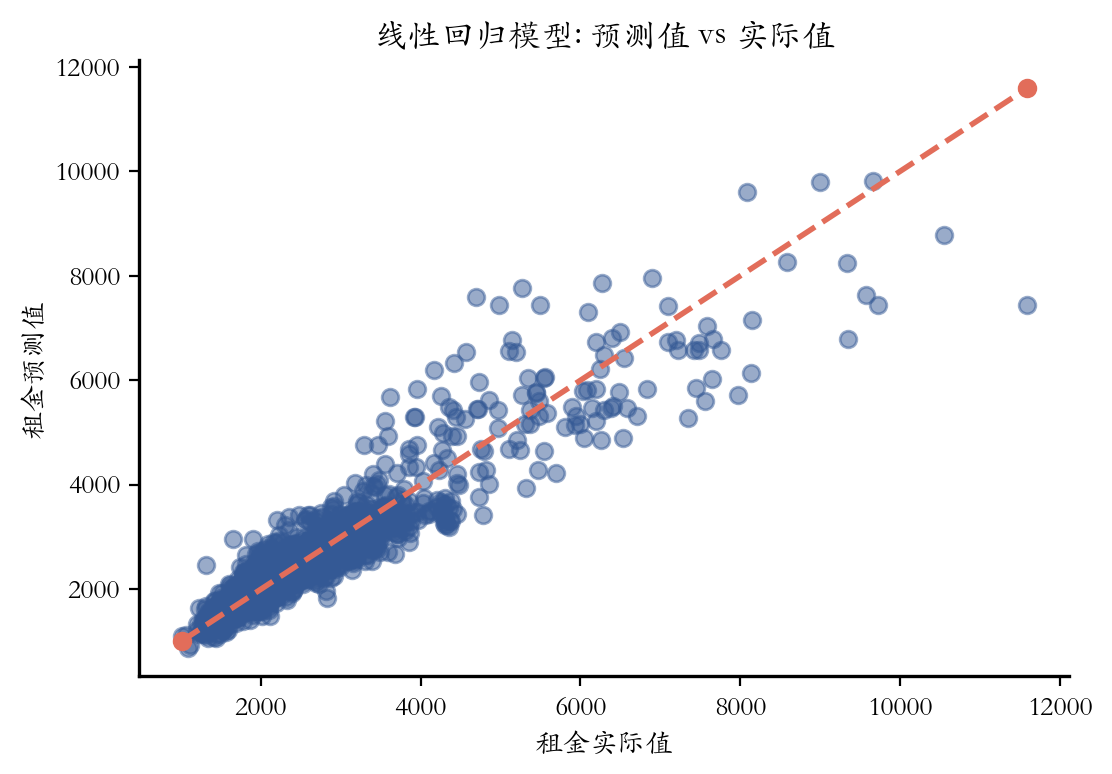


测试集预测值结果:
            编号   实际值   预测值    误差
0      28568-A  2200  2223   -23
1       9372-B  2970  2903    67
2      16902-D  2270  2151   119
3      32768-B  3410  3985  -575
4      71847-B  2530  2096   434
...        ...   ...   ...   ...
1658  125395-A  1070  1121   -51
1659    6441-C  2960  2647   313
1660  140526-C  1400  1664  -264
1661   36222-B  1860  2131  -271
1662  139628-A  2840  3289  -449

[1663 rows x 4 columns]


In [42]:
train_pred = model.predict(X_train_const)
test_pred = model.predict(X_test_const)

train_rmse = np.sqrt(np.mean((y_train - train_pred) ** 2))
test_rmse = np.sqrt(np.mean((y_test - test_pred) ** 2))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "o--", color="C1", lw=2
)
plt.xlabel("租金实际值")
plt.ylabel("租金预测值")
plt.title("线性回归模型: 预测值 vs 实际值")
plt.show()


prediction_results = pd.DataFrame(
    {
        "编号": test_df["编号"],
        "实际值": y_test,
        "预测值": test_pred.round().astype(int),
        "误差": y_test - test_pred.round().astype(int),
    }
).reset_index(drop=True)

print("\n测试集预测值结果:")
print(prediction_results)

prediction_results.to_csv("./prediction/point_estimation.csv", index=False, encoding="utf-8")

不难发现在租金较低的地方, 预测值和实际值的差距较小, 但是在租金较高的地方, 预测值和实际值的差距略大. 这说明该线性回归模型在预测租金较高的房子时, 有一定的误差. 但总体而言, 训练集和测试集的均方误差在合理范围内, 说明该模型具有较好的泛化能力.

**区间预测**

由于样本数量过多, 这里随机选取 30 个实际租金值小于4000的样本进行可视化展示.

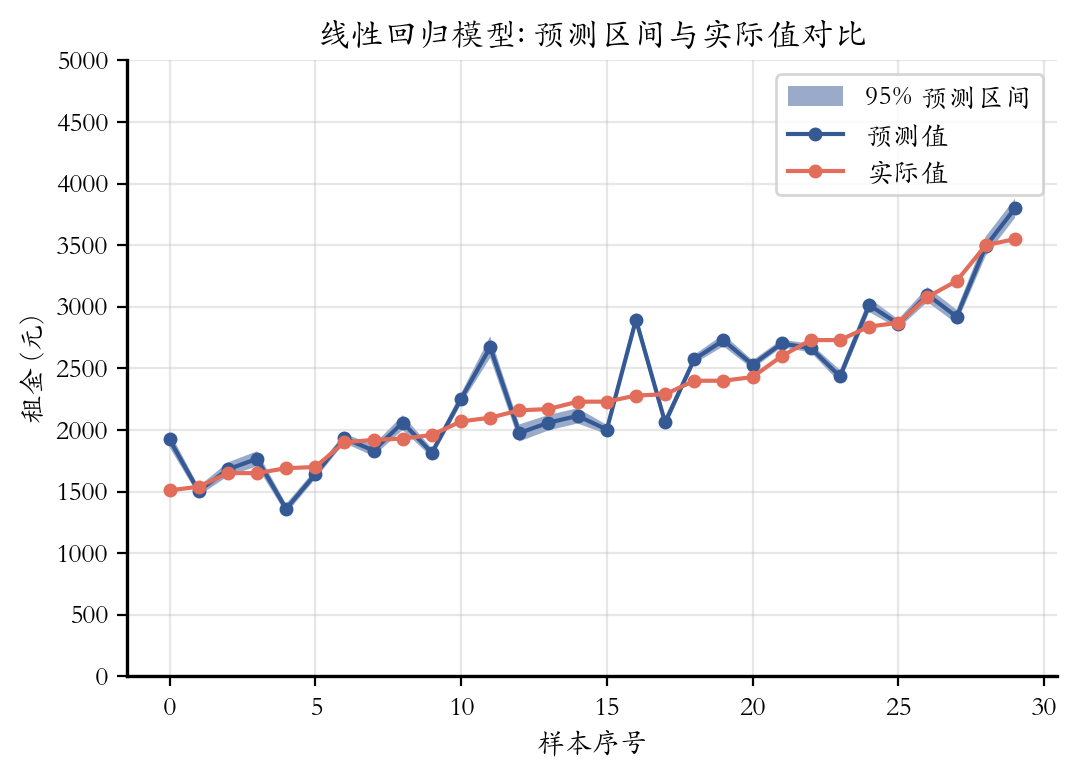


测试集预测值区间估计结果:
            编号   实际值   预测值  预测区间下限  预测区间上限
0      28568-A  2200  2223    2185    2262
1       9372-B  2970  2903    2854    2953
2      16902-D  2270  2151    2111    2191
3      32768-B  3410  3985    3856    4114
4      71847-B  2530  2096    2055    2137
...        ...   ...   ...     ...     ...
1658  125395-A  1070  1121    1064    1178
1659    6441-C  2960  2647    2609    2686
1660  140526-C  1400  1664    1602    1727
1661   36222-B  1860  2131    2079    2183
1662  139628-A  2840  3289    3256    3322

[1663 rows x 5 columns]


In [43]:
y_test_filtered = y_test[y_test <= 4000]
X_test_filtered = X_test_const.loc[y_test_filtered.index]

sample_idx = np.random.choice(len(X_test_filtered), size=30, replace=False)
X_test_sample = X_test_filtered.iloc[sample_idx]
y_test_sample = y_test_filtered.iloc[sample_idx]

predictions_sample = model.get_prediction(X_test_sample)
pred_summary_sample = predictions_sample.summary_frame(alpha=0.05)

sort_idx = np.argsort(y_test_sample)
y_sorted = y_test_sample.iloc[sort_idx]
pred_sorted = pred_summary_sample.iloc[sort_idx]

plt.fill_between(
    range(len(y_sorted)),
    pred_sorted["mean_ci_lower"],
    pred_sorted["mean_ci_upper"],
    alpha=0.5,
    label="95% 预测区间",
)

plt.plot(range(len(y_sorted)), pred_sorted["mean"], "o-", label="预测值", markersize=4)
plt.plot(range(len(y_sorted)), y_sorted, "o-", label="实际值", markersize=4)

plt.xlabel("样本序号")
plt.ylabel("租金 (元)")
plt.title("线性回归模型: 预测区间与实际值对比")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yticks(np.arange(0, 5500, 500))
plt.show()

predictions_all = model.get_prediction(X_test_const)
pred_summary_all = predictions_all.summary_frame(alpha=0.05)

prediction_results_interval = pd.DataFrame(
    {
        "编号": test_df["编号"],
        "实际值": y_test,
        "预测值": pred_summary_all["mean"].round().astype(int),
        "预测区间下限": pred_summary_all["mean_ci_lower"].round().astype(int),
        "预测区间上限": pred_summary_all["mean_ci_upper"].round().astype(int),
    }
).reset_index(drop=True)

print("\n测试集预测值区间估计结果:")
print(prediction_results_interval)

prediction_results_interval.to_csv(
    "./prediction/level_estimation.csv", index=False, encoding="utf-8"
)
